<a href="https://colab.research.google.com/gist/KhawajaMuddassar/e0933b60dd729506c6edf353348dc0ec/sam-batched-inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Segment Anything Model -SAM**

The Segment Anything Model (SAM) is a deep learning model developed by Meta (formerly Facebook) for image segmentation tasks. SAM is designed to enable users to efficiently segment objects within images, providing pixel-wise segmentation for any object with minimal input. It is a vision model that leverages a transformer-based architecture, allowing it to process images at a high level of abstraction. SAM employs a prompt-based approach, where users can provide various types of inputs, such as points, boxes, or text, to guide the segmentation process. The model's architecture is built around a vision transformer (ViT) backbone, which captures intricate image features, while the segmentation head outputs precise masks for objects of interest, making SAM highly flexible and capable of segmenting a wide range of objects in diverse contexts.

**Architecture:**
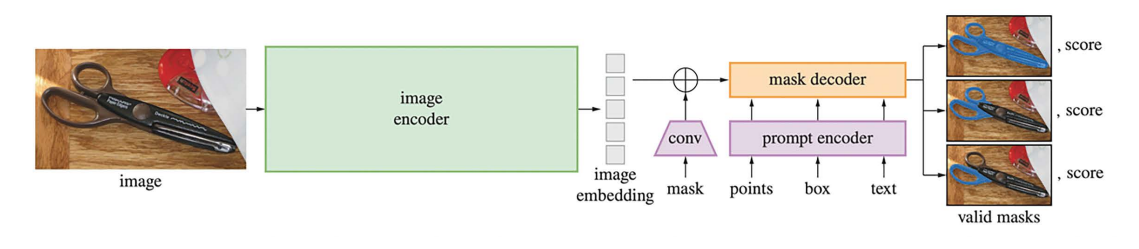


In the preceding image, the following steps are being performed:

1. An image is processed through an image encoder, which is a pre-trained vision transformer, to generate the corresponding image embeddings
2. Once the image embeddings are obtained, specific masks can be queried within the image by providing either dense masks (as shown in the figure above) or sparse masks, including points, boxes, and text
3. The prompt encoder processes inputs such as points, boxes, and masks, generating both dense and sparse embeddings. Point and box embeddings are constructed similarly to the embedding approach used in LayoutLM. Below, we explore the differences between the various types of masks:
    * **Dense masks** are ideal for scenarios where precise segmentation of complex objects is required, such as segmenting a person's hair or the leaves of a tree. In these cases, the user provides a rough contour of the desired mask, and SAM efficiently performs the task of extracting the detailed mask
    * **Sparse masks** are useful when we need to specify a text, bounding box, or point that corresponds to a specific region in the image, enabling targeted segmentation based on minimal user input
    * **If no mask, text, or point** input is provided, the model automatically generates 1,024 points uniformly distributed across the input image for the point encoder

    **Note:** In the case of a text prompt, it is processed through CLIP embeddings to obtain the corresponding text embedding when passed through the prompt encoder. For points and bounding boxes, they are represented by positional embeddings that correspond to the locations of the points or the boundaries of the boxes.
4. The embeddings are then fed into a mask decoder, which computes the attention between the prompt encoding and the image encoder, ultimately producing a set of segmentation masks

**Decoder Components**

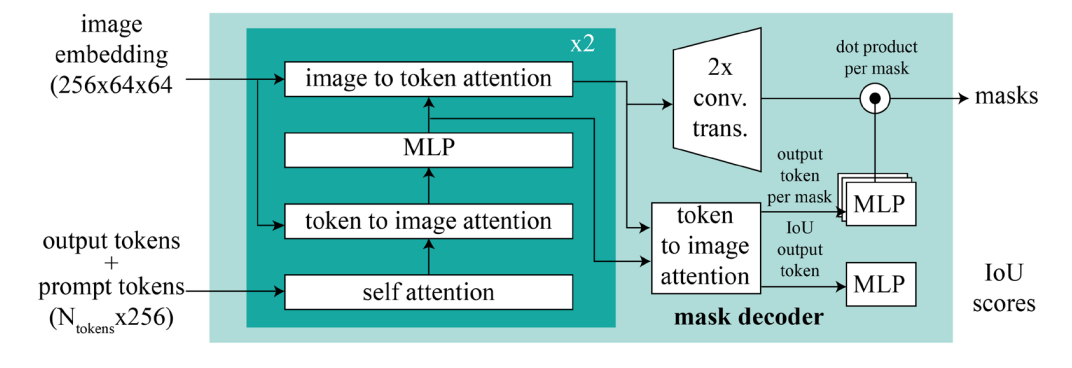

* **Image Embedding**: The process begins by generating an image embedding, which represents the input image as a set of feature vectors. These vectors are derived from the vision transformer, with each feature vector corresponding to a distinct image patch
* **Output Tokens + Prompt Tokens**: A prompt, such as a point, bounding box, or text, is represented as an embedding. Output tokens, akin to the CLS token in transformers, are learnable embeddings that encapsulate crucial information for effective segmentation. These tokens enable the generation of three potential masks corresponding to the given prompt
* **Attention Blocks**: These blocks function similarly to those in a transformer decoder, incorporating both self-attention (within the decoder output) and cross-attention between the encoder and decoder. This mechanism allows the model to effectively integrate and refine information from both the image and prompt embeddings for precise segmentation.
    * **Image to token attention:** This block helps the model to focus on specific features within the image embedding that are relevant to the tokens. It's a form of cross-attention
where image features inform the processing of the tokens.
    * **Token to image attention:** This does the reverse, allowing the tokens to influence the processing of the image features.
    * **Self-attention:** This mechanism allows the tokens to interact with each other, helping the model to integrate information across the different tokens
    * **Multilayer perceptron (MLP):** This is a neural network layer that processes the features from the attention mechanisms to transform and combine information further
    * **Iterations:** The attention blocks and MLPs are stacked in layers (as indicated by x2), allowing the model to refine its understanding of the image and prompt with each iteration.
    * **2x convolutional transpose:** This is an up-sampling operation that increases the spatial resolution of the feature maps. It's also known as deconvolution. This operation is used to go from a lower-resolution embedding back to the higher-resolution space of the original image, which is necessary for creating detailed masks
    * **Dot product per mask:** This step involves computing the dot product between the refined features and each potential mask. It's a way of scoring how well each feature corresponds to each mask, effectively aligning the feature vectors with the predicted masks
    * **Masks:** The result of the dot product per mask is used to generate the final segmentation masks. Each mask corresponds to a particular region or object in the image as defined by the prompt.
    * **Intersection over union (IoU) scores:** Alongside the mask generation, the model also outputs IoU scores. IoU measures the overlap between the predicted segmentation mask and the ground truth mask.


# **Object masks from prompts with SAM**

The SamPredictor class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the set_image method, which calculates the necessary image embeddings. Then, prompts can be provided via the predict method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install -q opencv-python matplotlib
!{sys.executable} -m pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Preparing metadata (setup.py) ... done


In [ ]:
# get images and model checkpoint
!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-01-03 02:38:55--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg’

truck.jpg           100%[===================>] 265.11K  --.-KB/s    in 0.02s   

2025-01-03 02:38:55 (10.8 MB/s) - ‘images/truck.jpg’ saved [271475/271475]

--2025-01-03 02:38:56--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

In [ ]:
# Utils Functions for Points, Box and Mask
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
# Load the SAM model and predictor
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# Process the image to produce an image embedding by calling SamPredictor.set_image.
# SamPredictor remembers this embedding and will use it for subsequent mask prediction.

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


**End-to-end batched inference**

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

In [ ]:
import cv2
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:

* image: The input image as a PyTorch tensor in CHW format.
* original_size: The size of the image before transforming for input to SAM, in (H, W) format.
* point_coords: Batched coordinates of point prompts.
* point_labels: Batched labels of point prompts.
* boxes: Batched input boxes.
* mask_inputs: Batched input masks.

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device)
    return image.permute(2, 0, 1).contiguous()

batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }]

# Run Model
batched_output = sam(batched_input, multimask_output=False)

The output is a list over results for each input image, where list elements are dictionaries with the following keys:

* masks: A batched torch tensor of predicted binary masks, the size of the original image.
* iou_predictions: The model's prediction of the quality for each mask.
* low_res_logits: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

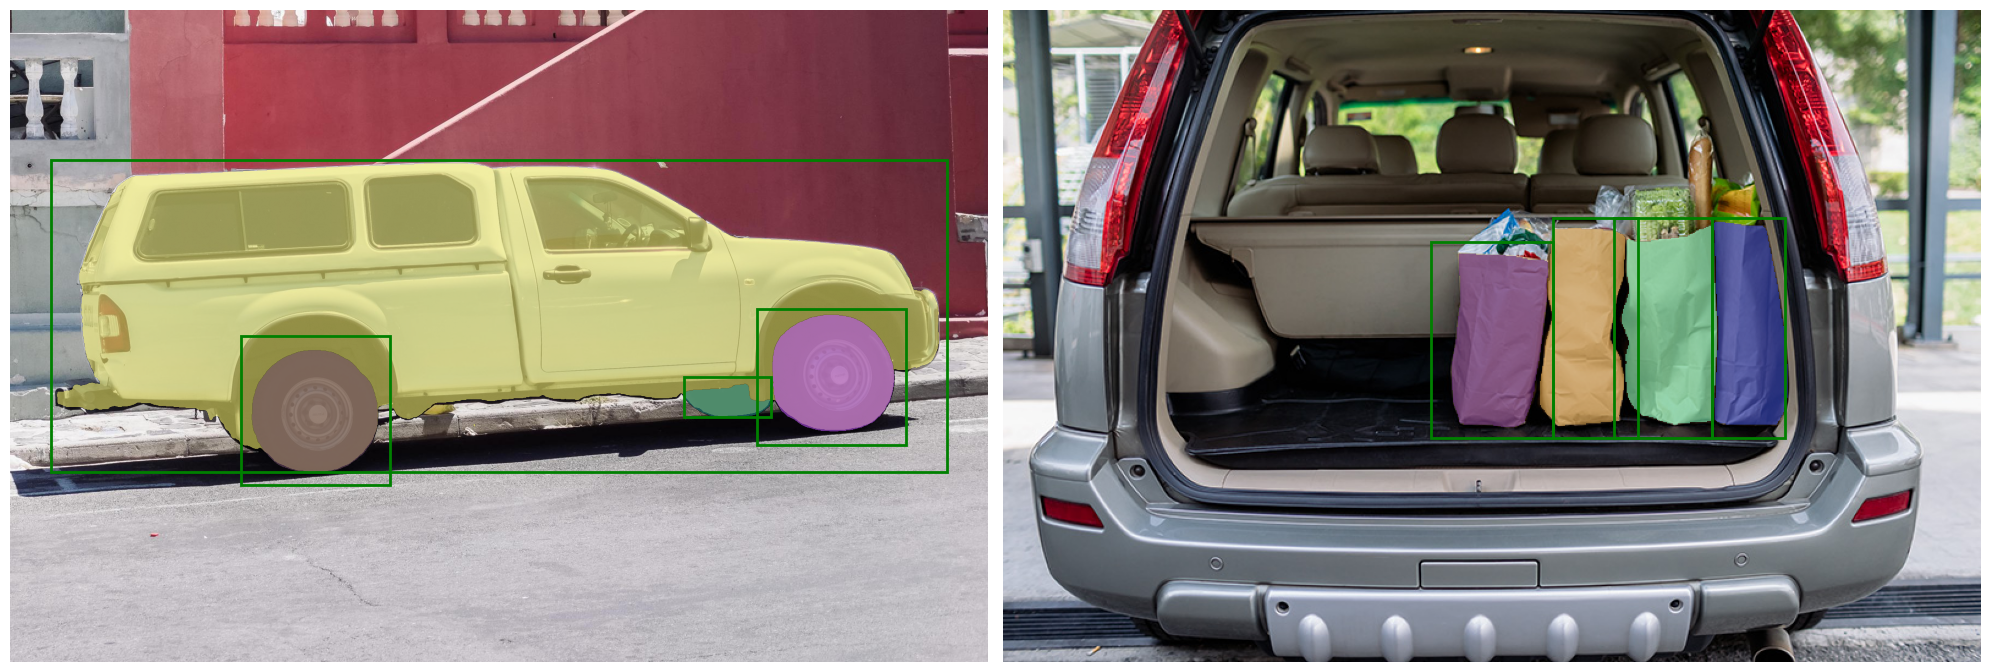

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()